In [8]:
from scoring_v2 import score_url_v2
import pandas as pd
import re
from urllib.parse import urlparse
from rapidfuzz import fuzz
from collections import Counter
from pathlib import Path

# === 0️⃣ Configuración de salida
OUTPUT_DIR = Path("../../../data/interim/phishing/phishing-database_v2")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# === 1️⃣ Cargar dataset desde .txt manualmente (una URL por línea)
with open("../../../data/raw/phishing/database-phishing.txt", "r", encoding="utf-8", errors="ignore") as f:
    lines = f.readlines()

urls = [line.strip() for line in lines if line.strip() != ""]
df = pd.DataFrame({"url": urls})
print(f"✅ Dataset cargado con {len(df)} URLs")

# === 2️⃣ Cargar whitelist española
whitelist_path = "../../../docs/spanish_domains.csv"
spanish_whitelist = pd.read_csv(whitelist_path)["domain"].str.lower().tolist()
print(f"✅ Whitelist cargada con {len(spanish_whitelist)} dominios")

# === 3️⃣ Aplicar nuevo sistema de scoring (v2)
df["score_total_v2"], df["signals_v2"] = zip(*df["url"].map(lambda u: score_url_v2(u, spanish_whitelist)))

# === 4️⃣ Filtrar y exportar por score
df_gte12 = df[df["score_total_v2"] >= 12]
df_8to12 = df[(df["score_total_v2"] > 8) & (df["score_total_v2"] < 12)]
df_le8  = df[df["score_total_v2"] <= 8]

df_gte12.to_csv(OUTPUT_DIR / "phishing_v2_score_gte12.csv", index=False)
df_8to12.to_csv(OUTPUT_DIR / "phishing_v2_score_8to12.csv", index=False)
df_le8.to_csv(OUTPUT_DIR / "phishing_v2_score_le8.csv", index=False)

print(f"✅ Exportados:")
print(f"   ≥7   → {len(df_gte12)} filas → {OUTPUT_DIR / 'phishing_v2_score_gte12.csv'}")
print(f"   4–7  → {len(df_8to12)} filas → {OUTPUT_DIR / 'phishing_v2_score_8to12.csv'}")
print(f"   ≤4   → {len(df_le8)} filas → {OUTPUT_DIR / 'phishing_v2_score_le8.csv'}")


✅ Dataset cargado con 1273433 URLs
✅ Whitelist cargada con 200 dominios
✅ Exportados:
   ≥7   → 2035 filas → ../../../data/interim/phishing/phishing-database_v2/phishing_v2_score_gte12.csv
   4–7  → 5843 filas → ../../../data/interim/phishing/phishing-database_v2/phishing_v2_score_8to12.csv
   ≤4   → 1265555 filas → ../../../data/interim/phishing/phishing-database_v2/phishing_v2_score_le8.csv


In [9]:
df["score_total_v2"].describe()
df["score_total_v2"].value_counts().sort_index()


score_total_v2
-5          6
-4        260
-3        980
-2      43040
-1       9932
 0     665661
 1     293388
 2     109635
 3      78839
 4      17920
 5      19081
 6      14255
 7       4013
 8       8545
 9       2435
 10      1851
 11      1557
 12       589
 13       587
 14       384
 15       170
 16       151
 17        83
 18        38
 19        21
 20        12
Name: count, dtype: int64

In [10]:
df_high = df[df["score_total_v2"] >= 14].copy()
print(len(df_high))


859


In [11]:
mask_compromised = df_high["url"].str.contains(r"\.es/.*/(wp-|plugins|themes|includes|vendor/|css|js|webmail)", case=False)
df_clean = df_high[~mask_compromised].copy()


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_3381/4201035245.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_compromised = df_high["url"].str.contains(r"\.es/.*/(wp-|plugins|themes|includes|vendor/|css|js|webmail)", case=False)


In [12]:
df_clean["domain"] = df_clean["url"].apply(lambda x: urlparse(x).netloc)
df_clean = df_clean.drop_duplicates(subset="domain")


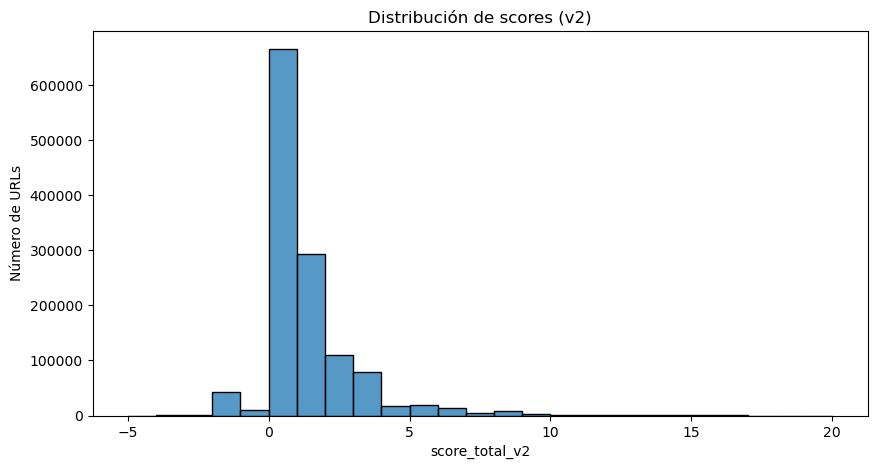

=== Estadísticas básicas del score ===
count    1.273433e+06
mean     8.508858e-01
std      1.702435e+00
min     -5.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      2.000000e+01
Name: score_total_v2, dtype: float64


score_total_v2
-5          6
-4        260
-3        980
-2      43040
-1       9932
 0     665661
 1     293388
 2     109635
 3      78839
 4      17920
 5      19081
 6      14255
 7       4013
 8       8545
 9       2435
 10      1851
 11      1557
 12       589
 13       587
 14       384
 15       170
 16       151
 17        83
 18        38
 19        21
 20        12
Name: count, dtype: int64


=== Percentiles ===
0.90    3.0
0.95    4.0
0.98    6.0
0.99    8.0
Name: score_total_v2, dtype: float64
Score ≥  8 → 16,423 URLs
Score ≥  9 → 7,878 URLs
Score ≥ 10 → 5,443 URLs
Score ≥ 11 → 3,592 URLs
Score ≥ 12 → 2,035 URLs
Score ≥ 13 → 1,446 URLs
Score ≥ 14 → 859 URLs
Score ≥ 15 → 475 URLs

=== Ejemplos score más altos ===


,url,score_total_v2,signals_v2
651268,https://ecarduar-bc20e9.ingress-baronn.ewp.liv...,19,spanish_brand:ing;spanish_brand:correos;spanis...
651269,https://ecarduar-bc20e9.ingress-baronn.ewp.liv...,19,spanish_brand:ing;spanish_brand:correos;spanis...
665309,https://entrega-estndar-baf1d3.ingress-baronn....,19,spanish_brand:ing;spanish_brand:correos;spanis...
665310,https://entrega-estndar-baf1d3.ingress-baronn....,19,spanish_brand:ing;spanish_brand:correos;spanis...
673173,https://etradano-bc20e9.ingress-daribow.ewp.li...,19,spanish_brand:ing;spanish_brand:correos;spanis...
673174,https://etradano-bc20e9.ingress-daribow.ewp.li...,19,spanish_brand:ing;spanish_brand:correos;spanis...
710978,https://generator-bc20e9.ingress-erytho.ewp.li...,19,spanish_brand:ing;spanish_brand:correos;spanis...
710979,https://generator-bc20e9.ingress-erytho.ewp.li...,19,spanish_brand:ing;spanish_brand:correos;spanis...
711621,https://gestin-particulares-es-10-b934ac.ingre...,19,spanish_brand:ing;spanish_brand:correos;spanis...
711622,https://gestin-particulares-es-10-b934ac.ingre...,19,spanish_brand:ing;spanish_brand:correos;spanis...



=== Ejemplos score 8–10 (zona media) ===


,url,score_total_v2,signals_v2
146588,http://iapp-buscar.com/index.php/false/false/p...,8,spanish_brand:ing;spanish_token:login;brand_an...
1147648,https://www.connexion-service.com/index.php/fa...,8,spanish_brand:ing;spanish_token:login;brand_an...
20381,http://accounhelp.dynv6.net/kajo5ssdrr9y/oauth...,8,spanish_brand:dgt;spanish_brand:dhl;spanish_to...
1234,http://0efbd9f.wcomhost.com/de/banking-postban...,10,spanish_brand:ing;spanish_token:login;brand_an...
1150,http://0efbd9f.wcomhost.com/de/banking-postban...,10,spanish_brand:ing;spanish_token:login;brand_an...
785656,https://kbexit.com/login.ionos,8,spanish_brand:ionos;spanish_token:login;brand_...
358538,https://0efbd9f.wcomhost.com/de/banking-postba...,10,spanish_brand:ing;spanish_token:login;brand_an...
178533,http://lauconsulting.co.za/cerdit/remit/login,8,spanish_brand:ing;spanish_token:login;brand_an...
358593,https://0f28d51.wcomhost.com/banking-postbank/...,10,spanish_brand:ing;spanish_token:login;brand_an...
1147920,https://www.correos-info.com/Recibir_paquete.php,10,spanish_brand:correos;spanish_token:paquete;sp...


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# === Distribución general del score ===
plt.figure(figsize=(10,5))
sns.histplot(df["score_total_v2"], bins=range(df["score_total_v2"].min(), df["score_total_v2"].max()+1), edgecolor="black")
plt.title("Distribución de scores (v2)")
plt.xlabel("score_total_v2")
plt.ylabel("Número de URLs")
plt.show()

# === Estadísticas descriptivas ===
desc = df["score_total_v2"].describe()
print("=== Estadísticas básicas del score ===")
print(desc)

# === Conteo por score exacto ===
score_counts = df["score_total_v2"].value_counts().sort_index()
display(score_counts)

# === Percentiles clave para decidir umbral ===
percentiles = df["score_total_v2"].quantile([0.90, 0.95, 0.98, 0.99])
print("\n=== Percentiles ===")
print(percentiles)

# === Estimación rápida de volumen por umbral ===
def volume_above(threshold):
    return (df["score_total_v2"] >= threshold).sum()

for th in range(8, 16):
    print(f"Score ≥ {th:2d} → {volume_above(th):,} URLs")

# === Vista previa de ejemplos extremos ===
print("\n=== Ejemplos score más altos ===")
display(df[df["score_total_v2"] >= df["score_total_v2"].max()-1][["url", "score_total_v2", "signals_v2"]].head(10))

print("\n=== Ejemplos score 8–10 (zona media) ===")
display(df[(df["score_total_v2"] >= 8) & (df["score_total_v2"] <= 10)][["url", "score_total_v2", "signals_v2"]].sample(10, random_state=1))


Total URLs con score ≥14: 859


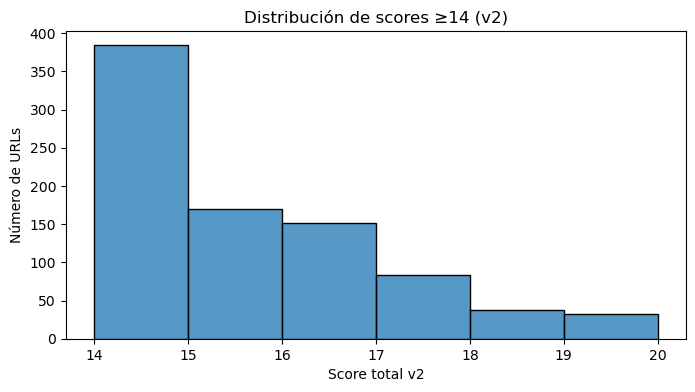


=== Dominios más repetidos ===


domain
000o8dc.wcomhost.com                                                32
044088d.wcomhost.com                                                16
telstra-bbdd52.ingress-earth.ewp.live                               14
php-gray-tiger-toegats436796.codeanyapp.com                         14
php-salmon-parrot-n0tyan6x907918.codeanyapp.com                     14
accesociaxatarieta-b31c49.ingress-erytho.ewp.live                   11
frejaiversen5441ejaxrqliqlbn9zce-b14e92.ingress-daribow.ewp.live     9
php-yellow-cricket-bonetamele607665.codeanyapp.com                   8
php-white-fish-jaklien865717.codeanyapp.com                          6
login-cbfa5.web.app                                                  6
govid-ba89b8.ingress-earth.ewp.live                                  6
easytools-1-bb787d.ingress-baronn.ewp.live                           6
ceskaposta-a71b59.ingress-daribow.ewp.live                           6
brothermeet-bb787d.ingress-comporellon.ewp.live                      6


=== Señales más comunes en score ≥14 ===


signals_v2
brand_and_spanish_token_boost       859
spanish_brand:ing                   729
tld_riesgo_alto                     691
foreign_tld_but_es_context          691
brand_in_subdomain                  645
host_ingress_pattern                512
spanish_token:sms                   324
path_verification_tokens:sms        318
brand_global_tld_boost              262
spanish_token:paquete               182
spanish_token:recibir               180
path_verification_tokens:recibir    179
spanish_brand:correos               142
brand_in_path:ing                   141
spanish_token:pago                  124
spanish_token:login                 115
spanish_token:pin                   109
spanish_marker:.es                  108
spanish_brand:santander              98
ing_false_positive                   92
ing_path_exception                   92
spanish_token:particulares           90
brand_in_path:santander              84
path_verification_tokens:pin         81
shortener_spain              


=== Ejemplos top (mayor score) ===


,url,score_total_v2,signals_v2
991091,https://servicio-clente-11-b8243a.ingress-baro...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
989517,https://servic-bd1e08.ingress-baronn.ewp.live/...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
991072,https://servicio-baffd6.ingress-bonde.ewp.live...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
991077,https://servicio-bb1348.ingress-bonde.ewp.live...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
991082,https://servicio-bc17ef.ingress-bonde.ewp.live...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
991069,https://servicio-baea8f.ingress-erytho.ewp.liv...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
991125,https://servicioelportal-particulare-bc8925.in...,20,spanish_brand:ing;spanish_brand:correos;spanis...
991090,https://servicio-clente-11-b8243a.ingress-baro...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
796947,https://lastbut-bc9a4f.ingress-florina.ewp.liv...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...
991251,https://servicoo-bad914.ingress-earth.ewp.live...,20,spanish_brand:bbva;spanish_brand:ing;spanish_t...



=== Ejemplos en el umbral (score = 14) ===


,url,score_total_v2,signals_v2
915431,https://php-salmon-elephant-toegats436796.code...,14,spanish_brand:ing;spanish_token:sms;spanish_ho...
908892,https://particularhomeweblogicsession-b1032f.i...,14,spanish_brand:ing;spanish_token:espera;brand_a...
1061987,https://trackingparcel-bb2af1.ingress-daribow....,14,spanish_brand:ing;spanish_brand:dhl;spanish_to...
1048645,https://telstra-bbdd52.ingress-earth.ewp.live/...,14,spanish_brand:ing;spanish_token:sms;brand_and_...
312270,http://portail02-d23348.ingress-erytho.ewp.liv...,14,spanish_brand:ing;spanish_brand:orange;spanish...
1170249,https://www.mydhl-international-express.au.igo...,14,spanish_brand:ing;spanish_brand:dhl;spanish_to...
189851,http://loc52.caixabank.es.lacaixa.actualizar.i...,14,spanish_brand:caixabank;spanish_token:forma;sp...
545041,https://cdfi-shoppingsite.web.app/verifyDelivery,14,spanish_brand:ing;spanish_token:pin;spanish_ho...
1170254,https://www.mydhl-international-express-fr.igo...,14,spanish_brand:ing;spanish_brand:dhl;spanish_to...
876509,https://newitemstracking-b20dcb.ingress-erytho...,14,spanish_brand:ing;spanish_token:sms;brand_and_...



Posibles hosts comprometidos (.es con rutas técnicas): 0


/var/folders/fc/53j7mrrs40j5jvl09zqzrcqw0000gn/T/ipykernel_3381/2746259345.py:54: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask_compromised = df_high["url"].astype(str).str.contains(pattern_compromised)


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
import pandas as pd
import re

# === 1️⃣ Filtrar subconjunto de alta puntuación ===
df_high = df[df["score_total_v2"] >= 14].copy()
print(f"Total URLs con score ≥14: {len(df_high):,}")

# === 2️⃣ Histograma de scores altos ===
plt.figure(figsize=(8,4))
sns.histplot(df_high["score_total_v2"], bins=range(14, df_high["score_total_v2"].max()+1), edgecolor="black")
plt.title("Distribución de scores ≥14 (v2)")
plt.xlabel("Score total v2")
plt.ylabel("Número de URLs")
plt.show()

# === 3️⃣ Dominios más frecuentes ===
df_high["domain"] = df_high["url"].apply(lambda x: urlparse(str(x)).netloc.lower())
top_domains = df_high["domain"].value_counts().head(15)
print("\n=== Dominios más repetidos ===")
display(top_domains)

# === 4️⃣ Señales más comunes (desglose de heurísticas activadas) ===
signals_series = (
    df_high["signals_v2"]
    .dropna()
    .astype(str)
    .str.split(";")
    .explode()
    .str.strip()
    .value_counts()
)

print("\n=== Señales más comunes en score ≥14 ===")
display(signals_series.head(25))

# === 5️⃣ Ejemplos de URLs más altas ===
top_examples = df_high.sort_values("score_total_v2", ascending=False).head(15)[["url", "score_total_v2", "signals_v2"]]
print("\n=== Ejemplos top (mayor score) ===")
display(top_examples)

# === 6️⃣ Ejemplos cercanos al umbral ===
border_examples = df_high[df_high["score_total_v2"] == 14].sample(10, random_state=42)
print("\n=== Ejemplos en el umbral (score = 14) ===")
display(border_examples[["url", "score_total_v2", "signals_v2"]])

# === 7️⃣ Patrón de host comprometido .es (solo verificación, sin eliminar aún) ===
pattern_compromised = re.compile(
    r"\.es(?:[:/]|$).*?(wp-|plugins|themes|includes|vendor/|phpunit|webmail|wp-admin|wp-content|vendor|/css|/js)",
    flags=re.IGNORECASE
)
mask_compromised = df_high["url"].astype(str).str.contains(pattern_compromised)
print(f"\nPosibles hosts comprometidos (.es con rutas técnicas): {mask_compromised.sum()}")
if mask_compromised.sum() > 0:
    display(df_high[mask_compromised][["url", "score_total_v2", "signals_v2"]].head(10))


URLs iniciales (score ≥14): 859
Detectados como posibles hosts comprometidos (.es): 0
URLs restantes tras eliminar comprometidos: 859
Dominios únicos antes del dedup: 411
Dominios únicos finales: 411
URLs finales tras deduplicar: 411


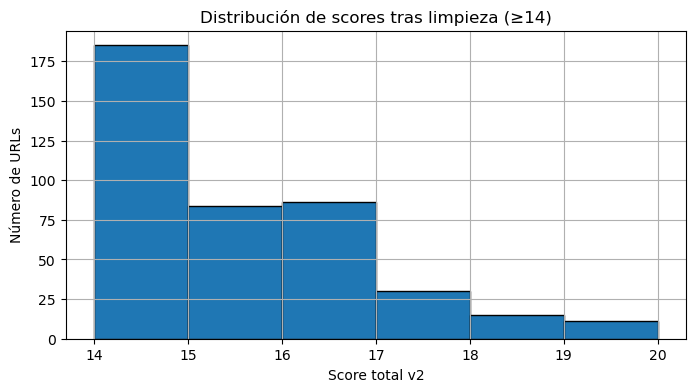


=== Primeras 10 URLs tras limpieza ===


,url,score_total_v2,domain
83,http://000o8dc.wcomhost.com/www.santanderbanco...,14,000o8dc.wcomhost.com
512,http://044088d.wcomhost.com/www.santanader.es/...,16,044088d.wcomhost.com
739,http://07bdd7c.wcomhost.com/ameliassurance-sms...,14,07bdd7c.wcomhost.com
861,http://0c4d4e6.wcomhost.com/banco-santander/pa...,16,0c4d4e6.wcomhost.com
11687,http://416363efax-2772-fi1e62ab.info6920.worke...,14,416363efax-2772-fi1e62ab.info6920.workers.dev
25104,http://alertanotificacionesdinamicos.com/verif...,14,alertanotificacionesdinamicos.com
34033,http://arstmping002.web.app,14,arstmping002.web.app
34035,http://arstmping003.web.app,14,arstmping003.web.app
34037,http://arstmping005.web.app,14,arstmping005.web.app
49440,http://bingo3-0.pages.dev/login.srf?wa=wsignin...,15,bingo3-0.pages.dev



=== 10 URLs aleatorias ===


,url,score_total_v2,domain
666544,https://equipocorreos3422-bb5b06.ingress-eryth...,17,equipocorreos3422-bb5b06.ingress-erytho.ewp.live
290374,http://pagos-correos-del.tempurl.host/es/manag...,14,pagos-correos-del.tempurl.host
479942,https://autrasistema-ba63ea.ingress-earth.ewp....,15,autrasistema-ba63ea.ingress-earth.ewp.live
1048624,https://telstra-2-997cef.ingress-baronn.ewp.li...,14,telstra-2-997cef.ingress-baronn.ewp.live
1061745,https://track-correosexpress.tempurl.host/es/r...,15,track-correosexpress.tempurl.host
523103,https://brothermeet-bb787d.ingress-comporellon...,14,brothermeet-bb787d.ingress-comporellon.ewp.live
1177538,https://www.redwood-consulting.com/particulare...,14,www.redwood-consulting.com
1265832,http://www.mydhl.global.express.ch.adhesint.co...,16,www.mydhl.global.express.ch.adhesint.com
596986,https://correosespana-b4c727.ingress-earth.ewp...,15,correosespana-b4c727.ingress-earth.ewp.live
1205251,https://yourbank-bc9a64.ingress-baronn.ewp.liv...,14,yourbank-bc9a64.ingress-baronn.ewp.live


In [16]:
import re
from urllib.parse import urlparse
import matplotlib.pyplot as plt

# === 1️⃣ Copiar subconjunto de trabajo (score ≥ 14)
df_work = df[df["score_total_v2"] >= 14].copy()
print(f"URLs iniciales (score ≥14): {len(df_work):,}")

# === 2️⃣ Detectar hosts comprometidos (.es con rutas técnicas)
pattern_compromised = (
    r"\.es(?:[:/]|$).*(?:wp-|plugins|themes|includes|vendor/|phpunit|webmail|"
    r"wp-admin|wp-content|vendor|/css|/js|phpmyadmin|administrator|/admin/|/cgi-bin)"
)

mask_compromised = df_work["url"].astype(str).str.contains(pattern_compromised, regex=True, case=False, na=False)
n_compromised = mask_compromised.sum()
print(f"Detectados como posibles hosts comprometidos (.es): {n_compromised:,}")

# Ver ejemplos (si existen)
if n_compromised > 0:
    print("\n=== Ejemplos de hosts comprometidos (.es) ===")
    display(df_work[mask_compromised][["url", "score_total_v2", "signals_v2"]].head(10))

# Eliminar comprometidos
df_clean = df_work[~mask_compromised].copy()
print(f"URLs restantes tras eliminar comprometidos: {len(df_clean):,}")

# === 3️⃣ Extraer dominio y deduplicar
df_clean["domain"] = df_clean["url"].apply(lambda x: urlparse(str(x)).netloc.lower())
n_domains_before = df_clean["domain"].nunique()

# Eliminar duplicados por dominio
df_clean = df_clean.drop_duplicates(subset="domain")
n_domains_after = df_clean["domain"].nunique()

print(f"Dominios únicos antes del dedup: {n_domains_before}")
print(f"Dominios únicos finales: {n_domains_after}")
print(f"URLs finales tras deduplicar: {len(df_clean)}")

# === 4️⃣ Distribución de scores tras limpieza
plt.figure(figsize=(8,4))
df_clean["score_total_v2"].hist(bins=range(14, df_clean["score_total_v2"].max()+1), edgecolor="black")
plt.title("Distribución de scores tras limpieza (≥14)")
plt.xlabel("Score total v2")
plt.ylabel("Número de URLs")
plt.show()

# === 5️⃣ Ejemplos para inspección visual
print("\n=== Primeras 10 URLs tras limpieza ===")
display(df_clean[["url", "score_total_v2", "domain"]].head(10))

print("\n=== 10 URLs aleatorias ===")
display(df_clean[["url", "score_total_v2", "domain"]].sample(10, random_state=42))


In [17]:
# === Crear DataFrame para limpieza manual ===
cols = [
    "url",
    "domain",
    "score_total_v2",
    "signals_v2",
    "sector",
    "entidad",
    "inclusion",
    "notas"
]

df_limpieza_manual = df_clean.copy()
for col in ["sector", "entidad", "inclusion", "notas"]:
    df_limpieza_manual[col] = ""

df_limpieza_manual = df_limpieza_manual[cols]

# === Comprobación rápida ===
print(f"DataFrame para limpieza manual creado con {len(df_limpieza_manual)} filas y {len(df_limpieza_manual.columns)} columnas.")
display(df_limpieza_manual.head(10))


DataFrame para limpieza manual creado con 411 filas y 8 columnas.


,url,domain,score_total_v2,signals_v2,sector,entidad,inclusion,notas
83,http://000o8dc.wcomhost.com/www.santanderbanco...,000o8dc.wcomhost.com,14,spanish_brand:santander;spanish_token:banco;sp...,,,,
512,http://044088d.wcomhost.com/www.santanader.es/...,044088d.wcomhost.com,16,spanish_brand:santander;spanish_token:banco;sp...,,,,
739,http://07bdd7c.wcomhost.com/ameliassurance-sms...,07bdd7c.wcomhost.com,14,spanish_brand:ing;spanish_token:login;spanish_...,,,,
861,http://0c4d4e6.wcomhost.com/banco-santander/pa...,0c4d4e6.wcomhost.com,16,spanish_brand:santander;spanish_token:banco;sp...,,,,
11687,http://416363efax-2772-fi1e62ab.info6920.worke...,416363efax-2772-fi1e62ab.info6920.workers.dev,14,spanish_brand:ing;spanish_token:sms;brand_and_...,,,,
25104,http://alertanotificacionesdinamicos.com/verif...,alertanotificacionesdinamicos.com,14,spanish_brand:ing;spanish_token:verificacion;s...,,,,
34033,http://arstmping002.web.app,arstmping002.web.app,14,spanish_brand:ing;spanish_token:pin;spanish_ho...,,,,
34035,http://arstmping003.web.app,arstmping003.web.app,14,spanish_brand:ing;spanish_token:pin;spanish_ho...,,,,
34037,http://arstmping005.web.app,arstmping005.web.app,14,spanish_brand:ing;spanish_token:pin;spanish_ho...,,,,
49440,http://bingo3-0.pages.dev/login.srf?wa=wsignin...,bingo3-0.pages.dev,15,spanish_brand:ing;spanish_token:login;spanish_...,,,,


In [18]:
df_limpieza_manual.to_csv(OUTPUT_DIR / "phishing_v2_limpieza_manual.csv", index=False, encoding="utf-8")


In [19]:
from urllib.parse import urlparse
from rapidfuzz import fuzz
import pandas as pd

# === 1️⃣ Preparar subconjunto
df_clonecheck = df_clean.copy()
df_clonecheck["domain"] = df_clonecheck["url"].apply(lambda u: urlparse(str(u)).netloc.lower())
df_clonecheck["path"] = df_clonecheck["url"].apply(lambda u: urlparse(str(u)).path.lower())

print(f"Total de URLs analizadas: {len(df_clonecheck)}")

# === 2️⃣ Detectar clones por dominio (mismo base)
duplicates_by_domain = (
    df_clonecheck.groupby("domain")["url"]
    .apply(list)
    .reset_index()
    .rename(columns={"url": "urls"})
)
duplicates_by_domain["num_urls"] = duplicates_by_domain["urls"].apply(len)
duplicates_by_domain = duplicates_by_domain[duplicates_by_domain["num_urls"] > 1]

print(f"\n🔍 Dominios con más de 1 URL detectada: {len(duplicates_by_domain)}")
display(duplicates_by_domain.head(10))

# === 3️⃣ Similaridad de rutas entre dominios distintos
# Buscamos rutas casi idénticas (>90%) para campañas clonadas en infra distintas
similar_pairs = []
urls = df_clonecheck[["url", "domain", "path"]].values.tolist()

for i in range(len(urls)):
    url1, dom1, path1 = urls[i]
    for j in range(i+1, len(urls)):
        url2, dom2, path2 = urls[j]
        if dom1 == dom2:
            continue  # ya analizado arriba
        sim = fuzz.ratio(path1, path2)
        if sim >= 90:
            similar_pairs.append({
                "url_1": url1,
                "url_2": url2,
                "similarity": sim,
                "path_1": path1,
                "path_2": path2
            })

df_similar = pd.DataFrame(similar_pairs).sort_values("similarity", ascending=False)
print(f"\n🔎 Pares de URLs con path >90% similar en dominios distintos: {len(df_similar)}")
display(df_similar.head(20))


Total de URLs analizadas: 411

🔍 Dominios con más de 1 URL detectada: 0


,domain,urls,num_urls



🔎 Pares de URLs con path >90% similar en dominios distintos: 1692


,url_1,url_2,similarity,path_1,path_2
0,http://alertanotificacionesdinamicos.com/verif...,https://sucursal-virtual-online.preview-domain...,100.0,/verificacion/estado/ingreso/proceso/estimado/...,/verificacion/estado/ingreso/proceso/estimado/...
1136,https://dhlshipping-60c93.web.app,https://partiiping-revoirien.web.app,100.0,,
1134,https://dhlshipping-60c93.web.app,https://ing.es-validacionmovil.info,100.0,,
1133,https://dhlshipping-60c93.web.app,https://ing.es-validacionacceso.info,100.0,,
1132,https://dhlshipping-60c93.web.app,https://ing.es-usuario.info,100.0,,
1131,https://dhlshipping-60c93.web.app,https://ing.es-ultimosaccesos.info,100.0,,
1130,https://dhlshipping-60c93.web.app,https://ing.es-tusaccesos.info,100.0,,
1129,https://dhlshipping-60c93.web.app,https://ing.es-tuacceso.info,100.0,,
1128,https://dhlshipping-60c93.web.app,https://ing.es-sesionescliente.info,100.0,,
1127,https://dhlshipping-60c93.web.app,https://ing.es-particulares.info,100.0,,


In [20]:
path_groups = (
    df_clonecheck["path"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "path", "path": "count"})
)
display(path_groups.head(20))


,count,count
0,,35
1,/pagomente/recibir_paquete.php,33
2,/shippings.php,13
3,/my-shopping-cart.php,9
4,/wp-content/plugins/celorivredniredit/pages/re...,8
5,/es/recibir_paquete.php,7
6,/loginon.php,6
7,/wp-content/plugins/pinepart/pages/region.php,5
8,/santander/clients/login.php,5
9,/acceso/es/clients/sms.php,4


In [21]:
df_clonecheck["path_base"] = (
    df_clonecheck["path"]
    .str.replace(r"[0-9a-f]{6,}", "", regex=True)
    .str.replace(r"[_\-]?[0-9]+", "", regex=True)
)


In [22]:
plantillas = df_clonecheck["path_base"].value_counts().head(20)
display(plantillas)


path_base
                                                             35
/pagomente/recibir_paquete.php                               33
/shippings.php                                               13
/my-shopping-cart.php                                         9
/wp-content/plugins/celorivredniredit/pages/region.php        8
/es/recibir_paquete.php                                       7
/loginon.php                                                  6
/wp-content/plugins/pinepart/pages/region.php                 5
/santander/clients/login.php                                  5
/bbva/area_cliente/confirmacionmovil.html                     4
/new%correos/pagomente/recibir_paquete.php                    4
/acceso/es/clients/sms.php                                    4
/wp-admin/user/santander/es/clients/login.php                 4
/necorreos/recibir_paquete.php                                3
/login/shippingdoc.htm                                        3
/banks/directing/tangerine/pin

In [25]:
df_clonecheck["duplicado"] = (
    df_clonecheck.duplicated(subset=["path_base"], keep="first").astype(int)
)


In [26]:
paths_a_excluir = [
    "35", "/es", "/wp-content/plugins/celorivredniredit/pages/region.php",
    "/wp-content/plugins/pinepart/pages/region.php"
]
df_filtrado = df_clonecheck[~df_clonecheck["path_base"].isin(paths_a_excluir)].copy()


In [27]:
df_final = df_filtrado.drop_duplicates(subset=["path_base"], keep="first")
print(f"URLs finales tras deduplicar por plantilla: {len(df_final)}")


URLs finales tras deduplicar por plantilla: 250


In [28]:
output_final = OUTPUT_DIR / "phishing_v2_dedup_plantilla.csv"
df_final.to_csv(output_final, index=False, encoding="utf-8")
print(f"💾 Exportado CSV limpio de 250 plantillas únicas a: {output_final}")


💾 Exportado CSV limpio de 250 plantillas únicas a: ../../../data/interim/phishing/phishing-database_v2/phishing_v2_dedup_plantilla.csv
